# Train delays and cancelled trains in switzerland 2019
Jupyter Notebook to inspect the average train delays and ampunt of cancelled trains for Switzerland in year 2019<br>
Data is provided by https://opentransportdata.swiss/de/, data for 2019 is stored in an google drive (https://drive.google.com/drive/folders/1SVa68nJJRL3qgRSPKcXY7KuPN9MuHVhJ)<br>
Data for the whole year was already downloaded and preprocessed (selecting train data only already calculate the delays). The preprocessed data is stored in two zip-files. delays.zip containing the delay for each train and train station and cancelled.zip containing data for cancelled trains for each train.<br>
2019 was choosen because 2020 is impacted by the corona crisis.<br>
Delays are counted if a trains is more than 3 minutes late (according to https://www.aargauerzeitung.ch/schweiz/unpunktliche-sbb-so-schummeln-sich-unsere-nachbarlander-ihre-zug-verspatungen-schon-ld.1358444)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from io import BytesIO

## Train delays 2019
### Loading and Preprocessing

In [2]:
#load data and first look
with ZipFile('./delays.zip', 'r') as zipObj:
    tmp_data = zipObj.read('delays.csv')
    df_delays = pd.read_csv(BytesIO(tmp_data), parse_dates=False)
    display(df_delays.head(3))
    display(df_delays.info())
    display(df_delays.describe())
del tmp_data

,BETRIEBSTAG,BETREIBER_ABK,BETREIBER_NAME,LINIEN_ID,LINIEN_TEXT,HALTESTELLEN_NAME,ANKUNFTSZEIT,AN_PROGNOSE,VERSPAETUNG
0,01.01.2019,NeTS-DB,NeTS Planung DB,19700.0,RB,Schaffhausen,2019-01-01 05:54:00,2019-01-01 05:54:00,0
1,01.01.2019,NeTS-DB,NeTS Planung DB,19702.0,RB,Schaffhausen,2019-01-01 06:24:00,2019-01-01 06:24:00,0
2,01.01.2019,NeTS-DB,NeTS Planung DB,19704.0,RB,Schaffhausen,2019-01-01 06:54:00,2019-01-01 06:54:00,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37647301 entries, 0 to 37647300
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   BETRIEBSTAG        object 
 1   BETREIBER_ABK      object 
 2   BETREIBER_NAME     object 
 3   LINIEN_ID          float64
 4   LINIEN_TEXT        object 
 5   HALTESTELLEN_NAME  object 
 6   ANKUNFTSZEIT       object 
 7   AN_PROGNOSE        object 
 8   VERSPAETUNG        int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 2.5+ GB


None

,LINIEN_ID,VERSPAETUNG
count,3.764730e+07,3.764730e+07
mean,1.271814e+04,-1.714960e+12
std,9.376804e+03,3.977148e+15
min,1.000000e+00,-9.223372e+18
25%,6.106000e+03,0.000000e+00
50%,1.247300e+04,0.000000e+00
75%,1.916900e+04,1.000000e+00
max,8.871360e+05,1.381000e+03


LINIEN_ID can be transformed to int<br>
The min, mean values for VERSPAETUNG are odd and need to be checked

In [3]:
#change type of LINIEN_ID to int
df_delays['LINIEN_ID'] = df_delays['LINIEN_ID'].astype(int)

In [4]:
#show min values
df_delays.loc[df_delays['VERSPAETUNG'] == df_delays['VERSPAETUNG'].min()]

,BETRIEBSTAG,BETREIBER_ABK,BETREIBER_NAME,LINIEN_ID,LINIEN_TEXT,HALTESTELLEN_NAME,ANKUNFTSZEIT,AN_PROGNOSE,VERSPAETUNG
18676974,23.06.2019,RBS,Regionalverkehr Bern-Solothurn,88215,S8,Moosseedorf,NaN,2019-06-23 21:48:00,-9223372036854775808
18677006,23.06.2019,RBS,Regionalverkehr Bern-Solothurn,88221,S8,Moosseedorf,NaN,2019-06-23 22:18:00,-9223372036854775808
18677038,23.06.2019,RBS,Regionalverkehr Bern-Solothurn,88225,S8,Moosseedorf,NaN,2019-06-23 22:47:00,-9223372036854775808
18677070,23.06.2019,RBS,Regionalverkehr Bern-Solothurn,88231,S8,Moosseedorf,NaN,2019-06-23 23:19:00,-9223372036854775808
18677102,23.06.2019,RBS,Regionalverkehr Bern-Solothurn,88235,S8,Moosseedorf,NaN,2019-06-23 23:49:00,-9223372036854775808
18677134,23.06.2019,RBS,Regionalverkehr Bern-Solothurn,88241,S8,Moosseedorf,NaN,2019-06-24 00:22:00,-9223372036854775808
20161022,23.07.2019,RhB,Rhätische Bahn,1310,RE,Zernez,NaN,2019-07-22 22:33:00,-9223372036854775808


Caused by NaN values in Arrival time<br>
--> anyway we are interessted in delays therefore I set negative delays to zero, so early arrivals don't give a bonus to average delay

In [5]:
df_delays.loc[df_delays['VERSPAETUNG'] < 0, 'VERSPAETUNG'] = 0
df_delays.describe()

,LINIEN_ID,VERSPAETUNG
count,3.764730e+07,3.764730e+07
mean,1.271814e+04,8.697987e-01
std,9.376804e+03,2.434919e+00
min,1.000000e+00,0.000000e+00
25%,6.106000e+03,0.000000e+00
50%,1.247300e+04,0.000000e+00
75%,1.916900e+04,1.000000e+00
max,8.871360e+05,1.381000e+03


In [6]:
#show train with maximum delay value
df_delays.loc[df_delays['VERSPAETUNG'] == df_delays['VERSPAETUNG'].max()]

,BETRIEBSTAG,BETREIBER_ABK,BETREIBER_NAME,LINIEN_ID,LINIEN_TEXT,HALTESTELLEN_NAME,ANKUNFTSZEIT,AN_PROGNOSE,VERSPAETUNG
19622763,18.07.2019,TPF,Transports publics fribourgeois,14416,S20,Givisiez,2019-07-18 05:35:00,2019-09-02 04:36:00,1381


more than 23hours delay that is impressive but also caused by an wrong value in the scheduled arrival time

In [7]:
print(f"Entries with trains who arrive more than 18h later:\n{df_delays.loc[df_delays['VERSPAETUNG'] > 1080].size}")

Entries with trains who arrive more than 18h later:
54


### Average delay

In [8]:
#mean and median delay if also punctual trains are considered
print(df_delays['VERSPAETUNG'].mean())
print(df_delays['VERSPAETUNG'].median())

0.8697986875606302
0.0


In [9]:
#mean and median delay if only delayed trains are considered
df_tmp = df_delays.loc[df_delays['VERSPAETUNG'] > 3]
print(df_tmp['VERSPAETUNG'].mean())
print(df_tmp['VERSPAETUNG'].median())
del df_tmp

6.548620533945446
5.0


For more detailed look, only look at major companies

In [10]:
#show amount of served lines per company, count lines only once per day
df_tmp = df_delays.drop_duplicates(subset=['BETRIEBSTAG', 'LINIEN_ID'])
df_served = df_tmp.groupby(['BETREIBER_ABK', 'BETREIBER_NAME'], as_index=False).agg({'LINIEN_ID' : np.size})
del df_tmp
df_served.rename(columns={'LINIEN_ID' : 'BEDIENTE_LINIEN_2019'}, inplace=True)
df_served['BEDIENTE_LINIEN_2019'] = df_served['BEDIENTE_LINIEN_2019'].astype(int)
df_served.sort_values(by='BEDIENTE_LINIEN_2019', ascending=False, inplace=True)
df_served

,BETREIBER_ABK,BETREIBER_NAME,BEDIENTE_LINIEN_2019
22,SBB,Schweizerische Bundesbahnen SBB,1875129
6,BLS-bls,BLS AG (bls),474450
26,THURBO,THURBO,405845
24,SOB-sob,Schweizerische Südostbahn (sob),119619
34,ZB,Zentralbahn,98319
20,RBS,Regionalverkehr Bern-Solothurn,98295
25,SZU,Sihltal-Zürich-Uetliberg-Bahn,96710
21,RhB,Rhätische Bahn,93979
28,TPF,Transports publics fribourgeois,65605
0,AB-ab,Appenzeller Bahnen (ab),57853


The most important companies are the SBB, BLS and THURBO. I will also look at the other SBB subsidiaries like Regionalps and SBB GmbH

In [11]:
#define list with companies and reduce dataframe
companies_list = ['SBB', 'BLS-bls', 'THURBO', 'SBB GmbH', 'RA']
df_delays_reduced = df_delays.loc[(df_delays['BETREIBER_ABK'].isin(companies_list)) & (df_delays['VERSPAETUNG'] > 3)]

In [12]:
df_delays_grouped = df_delays_reduced.groupby('BETREIBER_ABK', as_index=True).agg({'VERSPAETUNG' : [np.mean, np.std, np.median, np.min, np.max]})

In [13]:
df_delays_grouped

VERSPAETUNG                           
                     mean       std median amin amax
BETREIBER_ABK                                       
BLS-bls          5.610774  3.144455      5    4  377
RA               6.097110  3.687545      5    4  100
SBB              6.720946  6.288464      5    4  360
SBB GmbH         6.148446  3.929396      5    4  104
THURBO           5.432385  2.639763      5    4   65

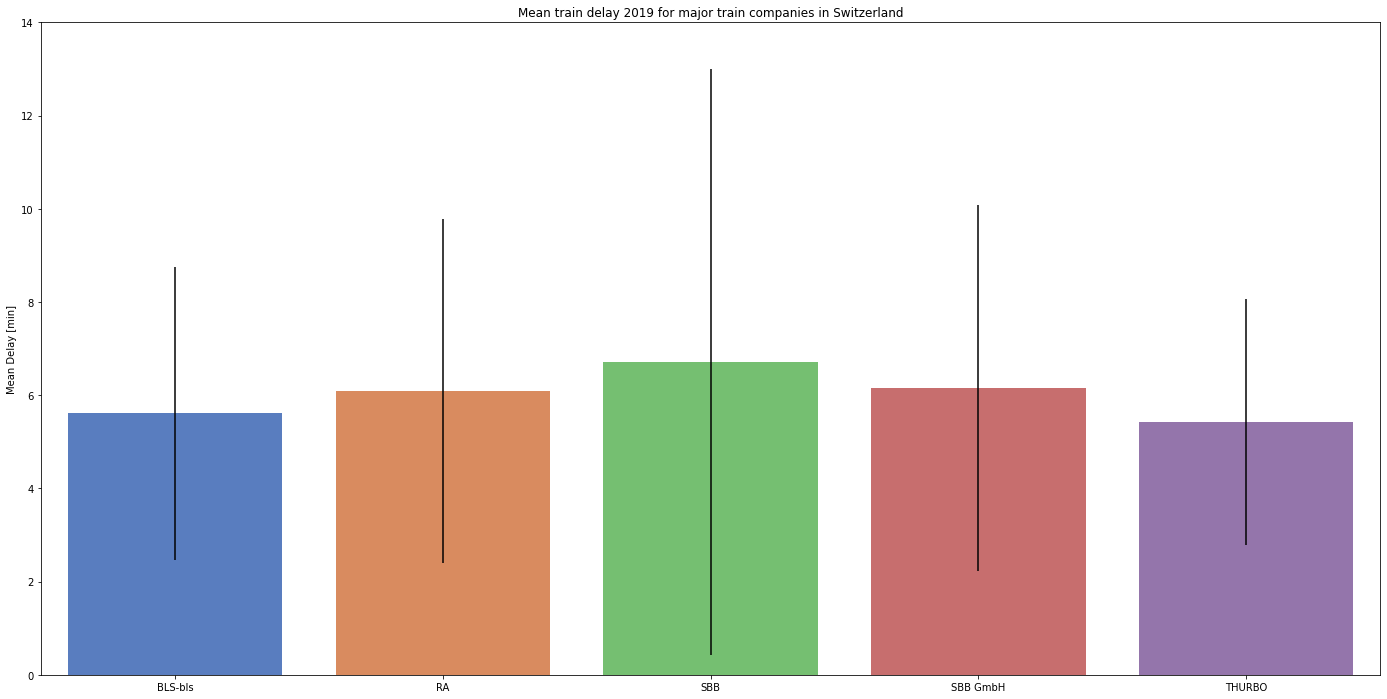

In [14]:
fig, ax = plt.subplots(figsize=(24,12))

bar = sns.barplot(data=df_delays_grouped,
        x=df_delays_grouped.index,
        y=df_delays_grouped.loc[:, ('VERSPAETUNG', 'mean')],
        yerr=df_delays_grouped.loc[:, ('VERSPAETUNG', 'std')], #height of errorbars
        palette="muted")

#changeplot settings
bar.set(ylim=(0,14), #Range y-Axis
        xlabel="", #Label x-Axis
        ylabel="Mean Delay [min]", #label y-axis
        title="Mean train delay 2019 for major train companies in Switzerland"); #Title

In [15]:
#pivot table to calc the percentage of delayed trains
df_tmp = df_delays.loc[df_delays['BETREIBER_ABK'].isin(companies_list)].copy()
df_tmp['VERSPAETET_TF'] = df_tmp['VERSPAETUNG'] > 3
df_tmp = df_tmp.drop_duplicates(subset=['BETREIBER_ABK', 'LINIEN_ID', 'BETRIEBSTAG'])
df_delays_percent = df_tmp.pivot_table('VERSPAETET_TF', ['BETREIBER_ABK'])
del df_tmp

In [16]:
df_delays_percent

,VERSPAETET_TF
BETREIBER_ABK,
BLS-bls,0.053084
RA,0.087142
SBB,0.054278
SBB GmbH,0.070514
THURBO,0.018266


~5.4% of the SBB and BLS trains are late. This is less the official values given by the SBB (https://reporting.sbb.ch/qualitaet?years=0,1,4,5,6,7&scroll=627). But could be due to ignoring trains which are cancelled and because here SBB and SBB GmbH are treated seperatly and I don't know how the SBB counts delayed trains. Interesstingly the THURBO is very punctual and the RegionAlps has a higher percentage of delayed trains

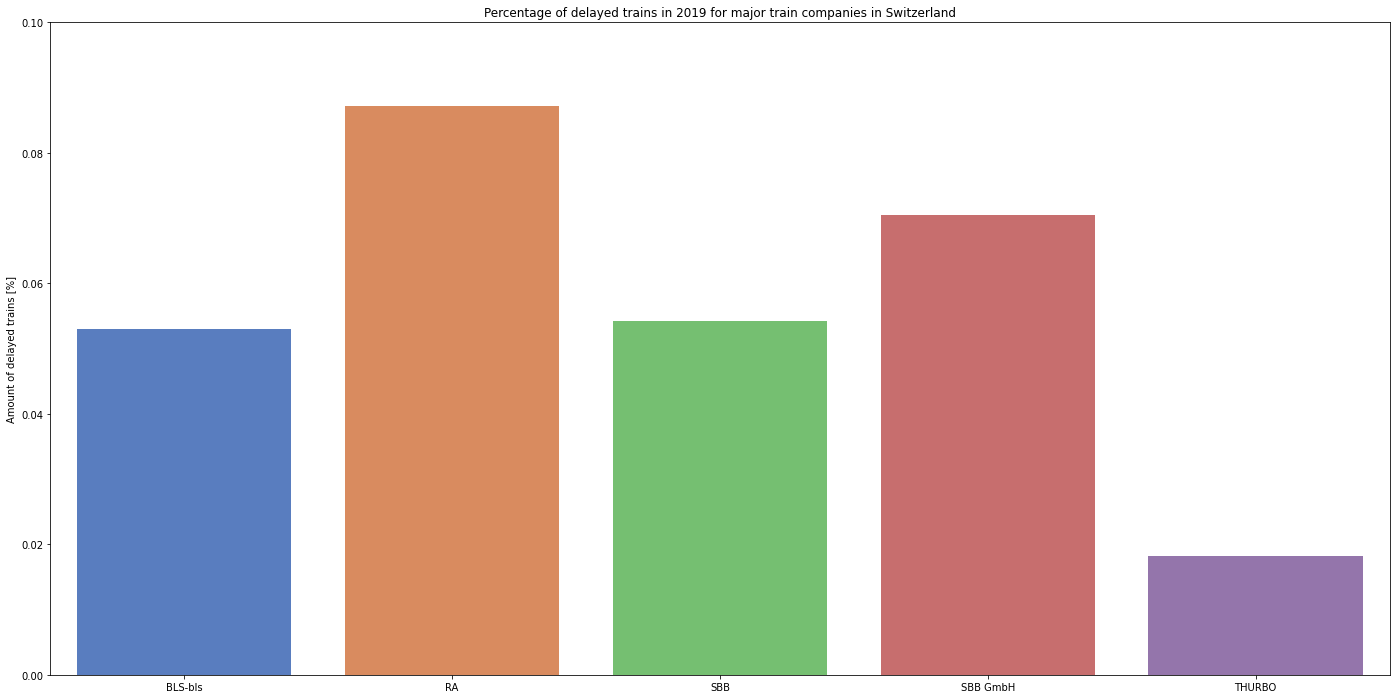

In [17]:
fig, ax = plt.subplots(figsize=(24,12))

bar = sns.barplot(data=df_delays_percent,
        x=df_delays_percent.index,
        y=df_delays_percent['VERSPAETET_TF'],
        palette="muted")

#changeplot settings
bar.set(ylim=(0,0.1), #Range y-Axis
        xlabel="", #Label x-Axis
        ylabel="Amount of delayed trains [%]", #label y-axis
        title="Percentage of delayed trains in 2019 for major train companies in Switzerland"); #Title

# Cancelled trains

In [18]:
#load data
with ZipFile('./cancelled.zip', 'r') as zipObj:
    tmp_data = zipObj.read('cancelled.csv')
    df_cancelled = pd.read_csv(BytesIO(tmp_data), parse_dates=False)
    display(df_cancelled.head(3))
    display(df_cancelled.info())
del tmp_data

,BETRIEBSTAG,BETREIBER_ABK,BETREIBER_NAME,LINIEN_ID,LINIEN_TEXT,FAELLT_AUS_TF,HALTESTELLEN_NAME
0,01.01.2019,DB,DB Regio AG Baden-Württemberg,17004.0,RE,False,Basel Bad Bf
1,01.01.2019,DB,DB Regio AG Baden-Württemberg,17011.0,RE,False,Basel Bad Bf
2,01.01.2019,DB,DB Regio AG Baden-Württemberg,17012.0,RE,False,Basel Bad Bf


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5032411 entries, 0 to 5032410
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   BETRIEBSTAG        object 
 1   BETREIBER_ABK      object 
 2   BETREIBER_NAME     object 
 3   LINIEN_ID          float64
 4   LINIEN_TEXT        object 
 5   FAELLT_AUS_TF      bool   
 6   HALTESTELLEN_NAME  object 
dtypes: bool(1), float64(1), object(5)
memory usage: 235.2+ MB


None

In [19]:
#drop duplicate lines so cancelled trains are only counted once per day
df_cancelled.drop_duplicates(subset=['LINIEN_ID', 'BETREIBER_ABK', 'FAELLT_AUS_TF', 'BETRIEBSTAG'], inplace=True)

In [20]:
#Only the larger companies
df_cancelled_reduced = df_cancelled.loc[df_cancelled['BETREIBER_ABK'].isin(companies_list)]

#pivot table to calc the percentage of canncelled trains
df_cancelled_percentage = df_cancelled_reduced.pivot_table('FAELLT_AUS_TF', ['BETREIBER_ABK'])

In [21]:
df_cancelled_percentage

,FAELLT_AUS_TF
BETREIBER_ABK,
BLS-bls,0.010177
RA,0.016484
SBB,0.021254
SBB GmbH,0.000981
THURBO,0.005989


~2.1% of the SBB trains are cancelled and only 1% percent of the BLS trains

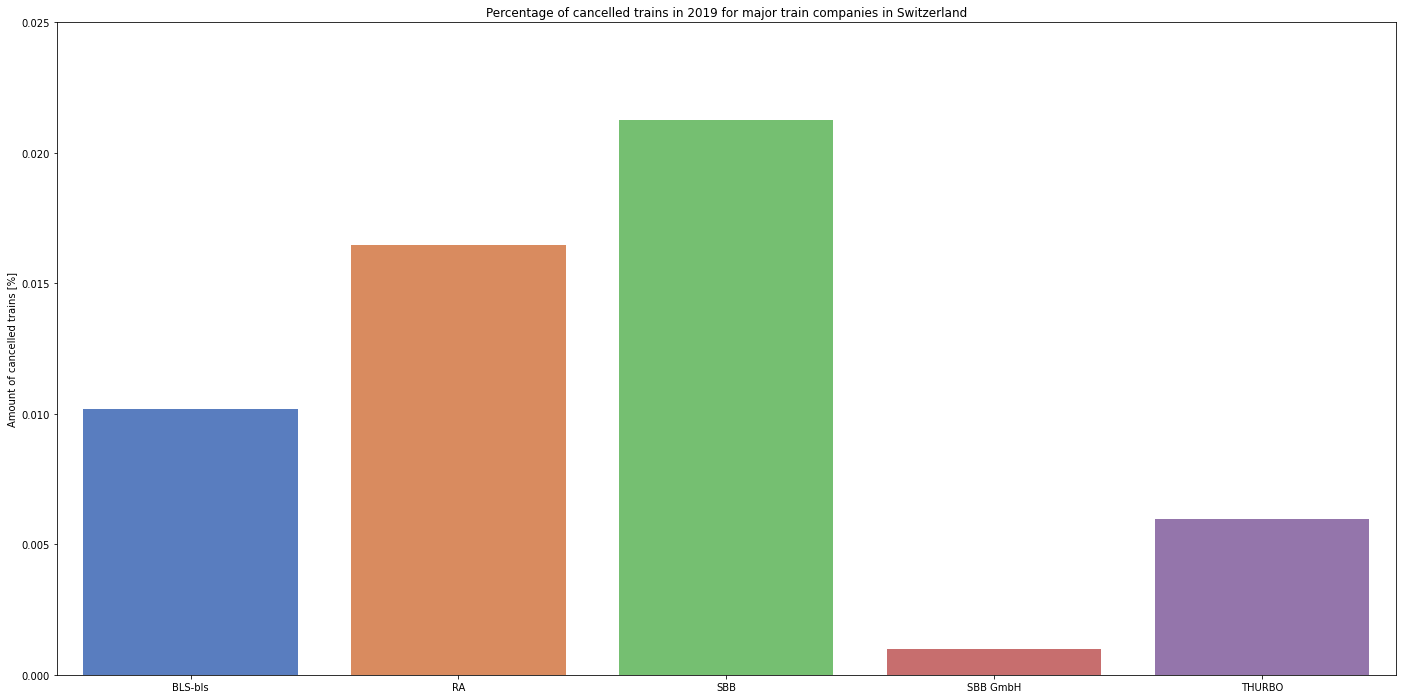

In [22]:
fig, ax = plt.subplots(figsize=(24,12))

bar = sns.barplot(data=df_cancelled_percentage,
        x=df_cancelled_percentage.index,
        y=df_cancelled_percentage['FAELLT_AUS_TF'],
        palette="muted")

#changeplot settings
bar.set(ylim=(0,0.025), #Range y-Axis
        xlabel="", #Label x-Axis
        ylabel="Amount of cancelled trains [%]", #label y-axis
        title="Percentage of cancelled trains in 2019 for major train companies in Switzerland"); #Title